In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from ipywidgets import widgets
from scipy.signal import find_peaks

plt.rcParams['figure.figsize'] = (16, 12)

## Periodicity in COVID-19 case data

Eyeballing the world case data there is a fairly obvious periodicity somewhere around 60 days. This notebook explores that pattern a bit more

In [2]:
dataCSV = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'

cDF = pd.read_csv(
    dataCSV,
    index_col='date',
    parse_dates=['date']
)

cDF.index = cDF.index - cDF.index.min()
cDF.head()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
date,,,,,,,,,,,,,,,,,,,,,
54 days,AFG,Asia,Afghanistan,1.0,1.0,NaN,NaN,NaN,NaN,0.026,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
55 days,AFG,Asia,Afghanistan,1.0,0.0,NaN,NaN,NaN,NaN,0.026,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
56 days,AFG,Asia,Afghanistan,1.0,0.0,NaN,NaN,NaN,NaN,0.026,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
57 days,AFG,Asia,Afghanistan,1.0,0.0,NaN,NaN,NaN,NaN,0.026,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
58 days,AFG,Asia,Afghanistan,1.0,0.0,NaN,NaN,NaN,NaN,0.026,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


Starting with the world data, look at the `new_cases` vs time since first case for the entire world

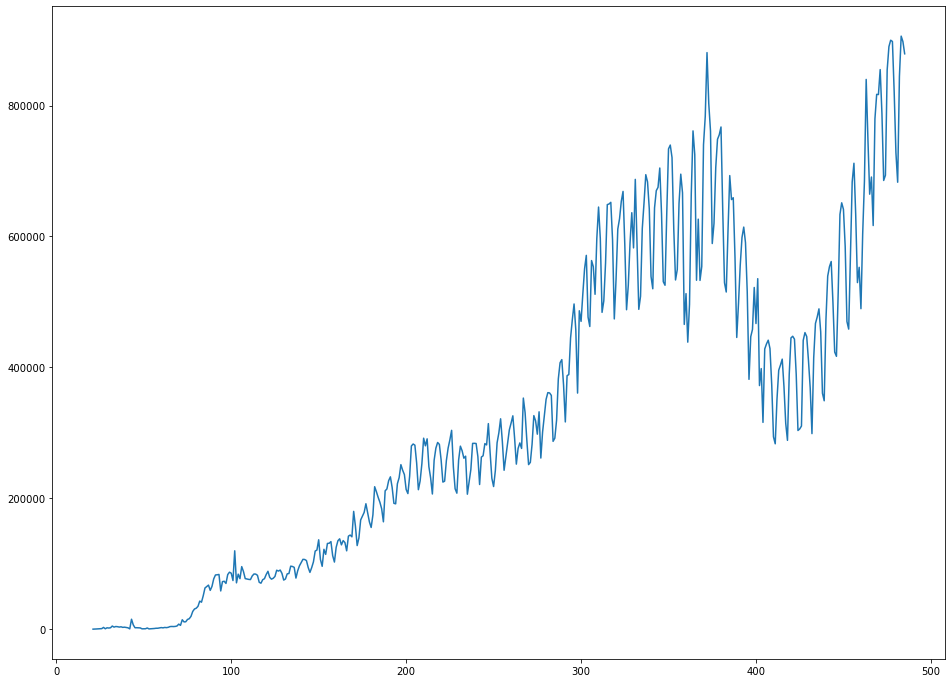

In [3]:
wDF = cDF[cDF['location'] == 'World'].dropna(subset=['new_cases'])

plt.plot(wDF.index.days, wDF.new_cases)

There's a fairly easy to spot periodicity about 50-70 days in length. Take a fourier transform and see if it stands out

In [4]:
ps = np.square(np.abs(np.fft.rfft(wDF.new_cases)))

In [5]:
d = np.arange((wDF.index.max() - wDF.index.min()).days / 2)

Toss the first couple of entries, because the data are reported ~daily

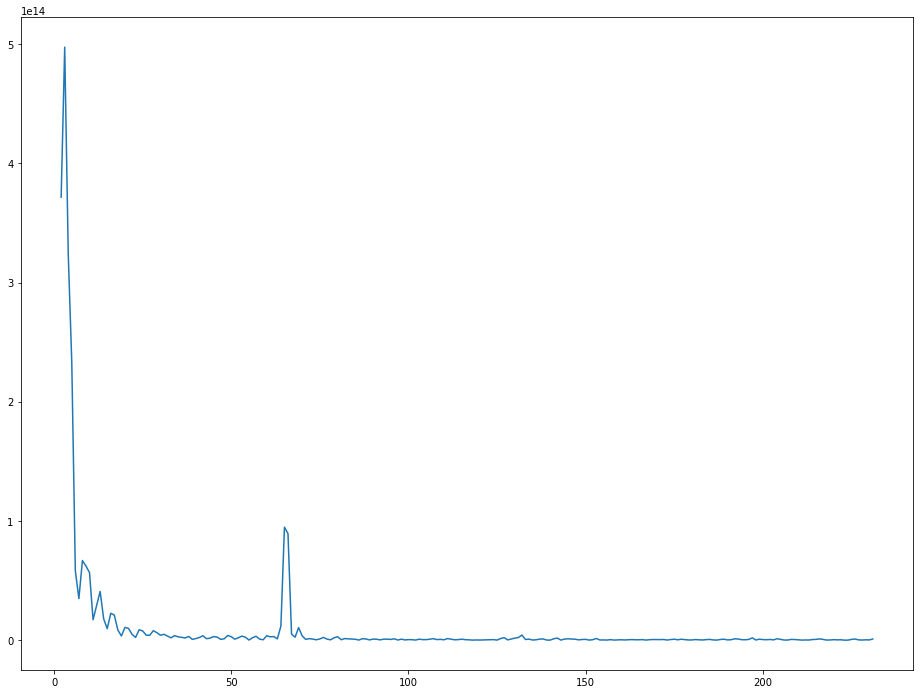

In [6]:
plt.plot(d[2:], ps[-len(d[2:]):])

So there is something there. Since the world data combines lots of reporting it's possible that this is just the data from one or two countries skewing the world data so let's start looking at individual locations. Try changing the dropdown below, here are some interesting countries to try:

### Show the 60 day spike
  * Brazil (wow!)
  * France
  * Germany (wow!)
  * Italy
  * Sweden (wow!)
  * United States
  * United Kingdom (a bit)
  * ...
  
### Don't show the 60 day spike
  * Canada
  * India
  * ...
  

In [7]:
def powerSpectrumCases(country):
    localDF = cDF[cDF['location'] == country].dropna(subset=['new_cases'])
    if len(wDF.new_cases > 10):
        ps = np.square(np.abs(np.fft.rfft(localDF.new_cases)))
        d = np.arange((localDF.index.max() - localDF.index.min()).days / 2)
        
        fig, ax = plt.subplots(1)
        ax.plot(d[2:], ps[-len(d[2:]):])
        plt.show()

a=widgets.interactive(
    powerSpectrumCases,
    country=widgets.Dropdown(
        options=sorted(set(cDF.location)),
        value = 'Sweden',
        description='Country:',
        disabled=False
    )
)
display(a)

interactive(children=(Dropdown(description='Country:', index=190, options=('Afghanistan', 'Africa', 'Albania',…

### Aggregating over countries

We can use `find_peaks` to try to identify peak locations and collect together common values.

<BarContainer object of 222 artists>

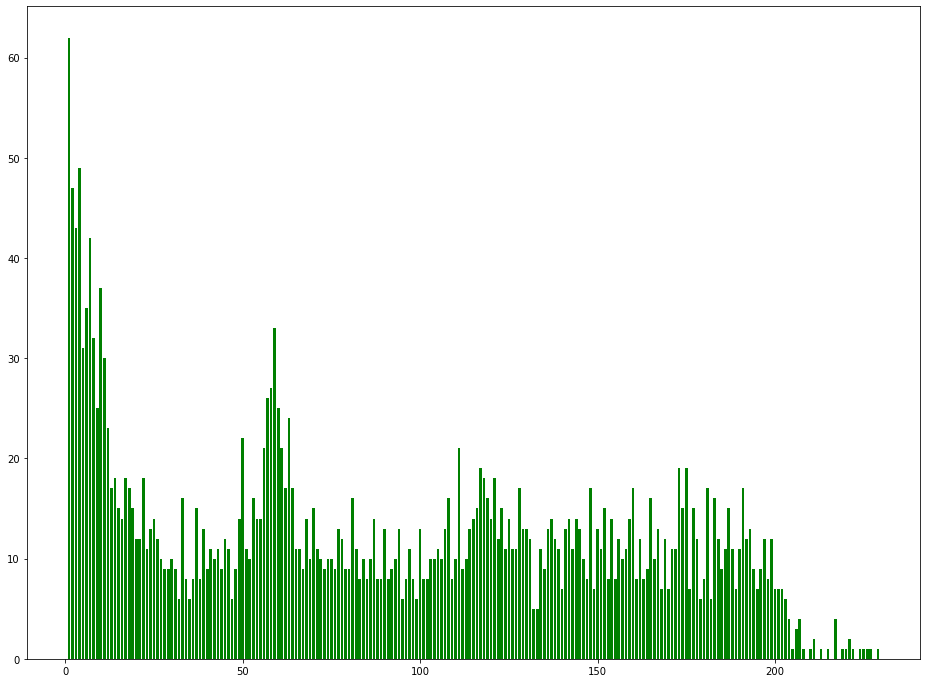

In [8]:
peaks = []
for country in set(cDF.location):
    localDF = cDF[cDF['location'] == country].dropna(subset=['new_cases'])
    if len(localDF.new_cases > 10):
        ps = np.square(np.abs(np.fft.rfft(localDF.new_cases)))
        d = np.arange((localDF.index.max() - localDF.index.min()).days / 2)
        peaks.append(find_peaks(ps[2:], threshold=max(ps[2:]) * 0.01)[0])

c = Counter(np.concatenate(peaks))
plt.bar(*zip(*c.most_common()), width=.75, color='g')

It's still there!

### Possible explainations

* Is this just an artifact of huge case counts in a few countries? e.g. There is a **huge** spike at ~60 days in Brazil, but it's there in lots of other countries as well. If it was related to the restrictions shouldn't there me more variation (different countries taking different approaches)
* Artifact of the data collection intervals?
* Seasonal artifact?
* Is is a coding or classification issue with the data?
* Other/something a mistake above?